# Track reconstruction validation

## In this notebook we are going to take the ROOT file produced by the validatetracksjob.fcl and make some plots!

Lets start by importing the relevant libraries

In [1]:
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt

Now, open the file we wish to collect the data from.

In [2]:
file = uproot.open('validationOutput.root')

directory = file['ana']
tree = directory['tree']
print('Tree name:', tree.name)
print('Tree title:', tree.title)
print('Number of entries:', tree.numentries)

Tree name: b'tree'
Tree title: b'Analysis Output Tree'
Number of entries: 84


Another way to access the tree would be tree = file['ana']['tree'].

Once the tree has been identified, we can access its keys, or variables. However, the size of those variables aren't all the same.

In [3]:
tree.keys()
tree.arrays()

{b'eventID': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  22,  23,  24,  26,  27,  30,  31,  32,
         33,  34,  35,  36,  39,  40,  41,  42,  43,  44,  45,  46,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,
         63,  65,  66,  68,  69,  70,  71,  73,  74,  76,  77,  78,  79,
         81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100], dtype=uint32),
 b'nPFParticles': array([ 5,  3,  2,  3,  6,  3,  4,  4, 12,  3,  3,  3,  2,  4,  4,  5,  4,
         3,  3,  3,  4,  3,  3,  6,  7,  3,  4,  4,  3,  3,  4,  4,  3,  2,
         2,  8,  3,  2,  3,  2,  3,  4,  2,  4,  4,  7,  3,  4,  2,  5,  6,
         2,  3,  2,  4,  4,  3,  4,  5,  2,  2,  4,  3,  4,  4,  4,  6,  2,
         5,  3,  3,  4,  3,  2,  2,  2,  4,  2,  5,  3,  2,  3,  5,  4],
       dtype=uint32),
 b'isPrimary': <JaggedArray [[False False False False True] [False False True] [

This array is a dictionary with annoying 'b' (byte) at the front. We can remove this by defining the branches as follow

In [4]:
branches = tree.arrays(namedecode='utf-8')
branches.keys()

dict_keys(['eventID', 'nPFParticles', 'isPrimary', 'nDaughters', 'particleID', 'particlePDG', 'Lengths', 'ValidPoints', 'StartDirPhi', 'StartDirZ', 'StartDirMag', 'StartX', 'StartY', 'StartZ', 'EndX', 'EndY', 'EndZ'])

In [5]:
print('eventID branch type:', type(branches['eventID']))
print('StartY branch type:', type(branches['StartY']))
branches['StartY']

eventID branch type: <class 'numpy.ndarray'>
StartY branch type: <class 'awkward.array.jagged.JaggedArray'>


<JaggedArray [[80.0566 81.86786] [144.03868] [-199.6801] ... [-121.9194] [-188.01895 -187.96637] [-36.51402]] at 0x00011d592e90>

The eventID branch is a simple numpy array. However, StartY is of another special kind: a jagged array. This is because the number of entries is different for different events.
We can look at them anyway! Note that there are square brackets [] surrounding the list of entries for each event. This is basically an array of arrays, or a 2D array. So we can look at the values for the collection of PFParticles of a particular event.

In [6]:
for i in range(10):
    print(branches['StartY'][i])

[80.0566  81.86786]
[144.03868]
[-199.6801]
[84.88349  84.823135]
[144.36487 162.59413 144.30197 145.04634]
[200.03487]
[-47.162586]
[-122.69484  -124.106544]
[123.516205 120.42123  120.727196 122.99127  106.68404 ]
[-141.14005]


The branches object that is not convenient for getting information from all branches at once for one particular event. We can get this functionality with a Table. Table is a class in the awkward package that uproot uses to handle jagged arrays. We can create a Table from our branches object:

In [7]:
table = awkward.Table(branches)
print(table[5]['StartX'])

[79.36575]


Now a given event we can see all the PFParticles' information at once for, say, the first event:

In [8]:
for column_name in table[0]:
    print(column_name, '=', table[0][column_name])

eventID = 1
nPFParticles = 5
isPrimary = [False False False False  True]
nDaughters = [0 0 0 0 4]
particleID = [0 1 2 3 4]
particlePDG = [11 13 13 11 12]
Lengths = [46.78872  25.828798]
ValidPoints = [176. 156.]
StartDirPhi = [-0.11911233  2.7008083 ]
StartDirZ = [0.75512373 0.8953484 ]
StartDirMag = [0.99999994 0.99999994]
StartX = [-180.33942 -181.30333]
StartY = [80.0566  81.86786]
StartZ = [475.30435 476.8262 ]
EndX = [-143.49002 -191.37592]
EndY = [65.63044  86.610855]
EndZ = [499.6893  500.13013]


## Let's actually plot something

### Numpy arrays
You will notice that plotting standard arrays is quite straight forward:

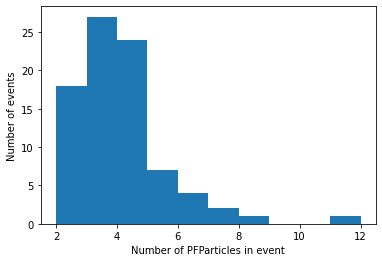

In [9]:
plt.hist(branches['nPFParticles'])
plt.xlabel('Number of PFParticles in event')
plt.ylabel('Number of events')
plt.show()

So straight forward that we didn't really have to go through all the hasle above as we could have simply declared a data frame:

<AxesSubplot:ylabel='Frequency'>

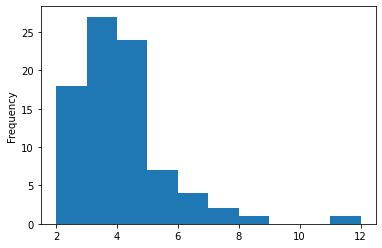

In [10]:
df_reco = file['ana']['tree'].pandas.df('*', flatten=False)
#print(df_reco)
df_reco['nPFParticles'].plot.hist()

However, neither the branch or the data frame offer a solution for plotting all the PFParticle information. For instance, you'd get an error if you tried doing df_reco['Lenghts'].plot.hist()

### Jagged arrays

As matplot expects 1D arrays, we'd need to flatten the jagged 2D array into a 1D array. Simply add .flatten() to the branch array:

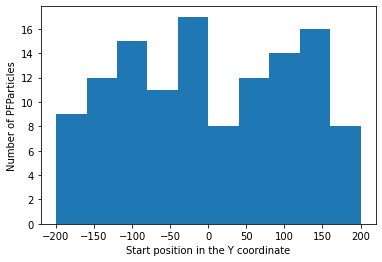

In [11]:
plt.hist(branches['StartY'].flatten())
plt.xlabel('Start position in the Y coordinate')
plt.ylabel('Number of PFParticles')
plt.show()

## Counting entries

All of the following should coincide

In [12]:
print('number of events from')
print('len(tree): ', len(tree))
print('len(table): ', len(table))
print('len(branches[\'nPFParticles\']): ', len(branches['nPFParticles']))
print('len(branches[\'StartY\']): ', len(branches['StartY']))

number of events from
len(tree):  84
len(table):  84
len(branches['nPFParticles']):  84
len(branches['StartY']):  84


This is not the total number of PFParticles nor the total number of tracks. If we want those variables:

In [13]:
print('number or pfparticles:', sum(branches['nPFParticles']))
print('number of tracks:', len(branches['StartY'].flatten())) # or any other branch

number or pfparticles: 306
number of tracks: 122


Note that the number of PFParticles is not the same as tracks. This is because they were either reconstructed as showers or not reconstructed at all.

## Selection

Say we want to only select the events or PFParticles that fullfill certain criteria. For example, select all the events that have at least one PFParticle. The way we define we do this is by defining a dataframe:

In [14]:
branches['nPFParticles'] >= 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [15]:
pfparticles_sel = branches['nPFParticles'] > 1
pfparticles_sel.sum() # summing the events passing the selection

84

We can see that all the events have at least one PFParticle. That's not that interesting so let's try something else. I want to know which tracks are longer than 50 cm:

In [16]:
longtracks_sel = branches['Lengths'] > 50
print(longtracks_sel)
longtracks_sel.sum()

[[False False] [False] [False] ... [False] [False False] [True]]


array([0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1])

So only 56 out of the 122 tracks are longer than 50 cm. We can now use this selection and apply it to our data. For example, if I want the the start position in the Y direction of those long tracks:

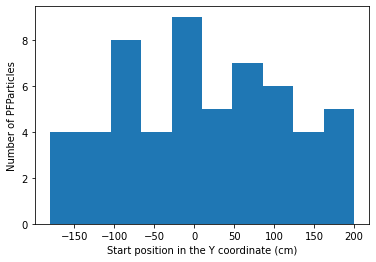

In [17]:
longtracks_starty = branches['StartY'][longtracks_sel]
plt.hist(longtracks_starty.flatten())
plt.xlabel('Start position in the Y coordinate (cm)')
plt.ylabel('Number of PFParticles')
plt.show()

That plot surely looks different from the one we created above. Another way to check if we did everything right is by directly looking at the length distribution when using this selection. We should only see lenghts greater than 50 cm plotted:

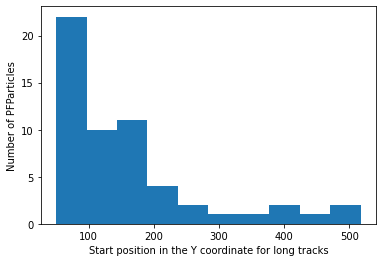

In [18]:
longtracks = branches['Lengths'][longtracks_sel]
plt.hist(longtracks.flatten())
plt.xlabel('Start position in the Y coordinate for long tracks')
plt.ylabel('Number of PFParticles')
plt.show()